<a href="https://colab.research.google.com/github/maxvb-2003/Data-Science/blob/main/Modified_(Data_Science)_Ethnicity_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import Point
import matplotlib.cm as cm
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def printMatrix(preds, title, model):
  class_names = ['Black/African American', 'Hispanic/Latino', 'White/Caucasian']
  cm = confusion_matrix(y_test, preds, normalize='true')

  # Get more detailed metrics
  precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average=None)
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1 Score: {f1}")

  # Calculate AUC-ROC
  if hasattr(model, "predict_proba"):
      y_pred_proba = model.predict_proba(X_test)[:,1]
      auc = roc_auc_score(y_test, y_pred_proba)
      print(f"AUC-ROC: {auc:.4f}")

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f',
              xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted Outcome')
  plt.ylabel('Actual Outcome')
  plt.title(f'{title}')
  plt.tight_layout()
  plt.show()

In [ ]:
def printMatrix(preds, title, model):
  class_names = ['Black/African American', 'Hispanic/Latino', 'White/Caucasian']
  cm = confusion_matrix(y_test, preds, normalize='true')

  # Get more detailed metrics
  precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average=None)
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1 Score: {f1}")

  # Calculate AUC-ROC
  if hasattr(model, "predict_proba"):
      y_pred_proba = model.predict_proba(X_test)[:,1]
      # Add multi_class='ovr' for multi-class classification
      auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr') # added multi_class='ovr'
      print(f"AUC-ROC: {auc:.4f}")

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f',
              xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted Outcome')
  plt.ylabel('Actual Outcome')
  plt.title(f'{title}')
  plt.tight_layout()
  plt.show()

In [ ]:
def printMatrix(preds, title, model):
  class_names = ['Black/African American', 'Hispanic/Latino', 'White/Caucasian']
  cm = confusion_matrix(y_test, preds, normalize='true')

  # Get more detailed metrics
  precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average=None)
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1 Score: {f1}")

  # Calculate AUC-ROC
  if hasattr(model, "predict_proba"):
      # Get probabilities for all classes
      y_pred_proba = model.predict_proba(X_test)
      # Ensure y_pred_proba has the correct shape for multi-class AUC calculation
      if y_pred_proba.shape[1] == len(class_names):
          auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
          print(f"AUC-ROC: {auc:.4f}")
      else:
          print("Warning: Could not calculate AUC-ROC. Model may not be suitable for multi-class classification.")

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f',
              xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted Outcome')
  plt.ylabel('Actual Outcome')
  plt.title(f'{title}')
  plt.tight_layout()
  plt.show()

In [ ]:
modeling_df = pd.read_csv('/content/drive/Shareddrives/Project 3 (Arrest Dataset)/clean_arrest_data.csv')

In [ ]:
modeling_df = modeling_df.copy()
# Convert the date columns to datetime format
modeling_df['Arrest_DateTime'] = pd.to_datetime(modeling_df['Arrest Date'], errors='coerce')
modeling_df['Booking_DateTime'] = pd.to_datetime(modeling_df['Booking Date'], errors='coerce')
# Extract day, month, and year for Arrest Date
modeling_df['Arrest_Day'] = modeling_df['Arrest_DateTime'].dt.day
modeling_df['Arrest_Month'] = modeling_df['Arrest_DateTime'].dt.month
modeling_df['Arrest_Year'] = modeling_df['Arrest_DateTime'].dt.year
# Extract day, month, and year for Booking Date
modeling_df['Booking_Day'] = modeling_df['Booking_DateTime'].dt.day
modeling_df['Booking_Month'] = modeling_df['Booking_DateTime'].dt.month
modeling_df['Booking_Year'] = modeling_df['Booking_DateTime'].dt.year
modeling_df = modeling_df.drop(columns=['Arrest Date', 'Booking Date', 'Arrest_DateTime', 'Booking_DateTime'])
# Updated mapping dictionary for recoding
descent_mapping = {
    # Hispanic/Latino
    'H': 'Hispanic/Latino',
    # Black/African American
    'B': 'Black/African American',
    # White/Caucasian
    'W': 'White/Caucasian',
    # Asian/Pacific Islander (combining Asian and Pacific Islander)
    'A': 'Other/Unknown',
    'C': 'Other/Unknown',
    'F': 'Other/Unknown',
    'K': 'Other/Unknown',
    'J': 'Other/Unknown',
    'Z': 'Other/Unknown',
    'D': 'Other/Unknown',
    'V': 'Other/Unknown',
    'L': 'Other/Unknown',
    'G': 'Other/Unknown',  # Guamanian
    'P': 'Other/Unknown',  # Pacific Islander
    'U': 'Other/Unknown',  # Hawaiian
    'S': 'Other/Unknown',  # Samoan
    # Other/Unknown (including Native American due to small numbers)
    'I': 'Other/Unknown',  # American Indian/Alaska Native
    'O': 'Other/Unknown',
    'X': 'Other/Unknown'
}
# Apply the mapping to create a new column
modeling_df['Ethnicity'] = modeling_df['Descent Code'].map(descent_mapping)
# Check the distribution of the new ethnicity categories
print("Ethnicity Distribution:")
print(modeling_df['Ethnicity'].value_counts())
print(modeling_df['Ethnicity'].value_counts(normalize=True).map('{:.1%}'.format))
modeling_df = modeling_df.drop(columns=['Descent Code'])

Ethnicity Distribution:
Ethnicity
Hispanic/Latino           159620
Black/African American     84918
White/Caucasian            49060
Other/Unknown              18368
Name: count, dtype: int64
Ethnicity
Hispanic/Latino           51.2%
Black/African American    27.2%
White/Caucasian           15.7%
Other/Unknown              5.9%
Name: proportion, dtype: object


In [ ]:
# drop rows where Ethnicity is 'Other/Unknown'
modeling_df = modeling_df[modeling_df['Ethnicity'] != 'Other/Unknown']

# reset index after filtering
modeling_df = modeling_df.reset_index(drop=True)

# check the distribution after dropping
print("Ethnicity Distribution (after dropping Other/Unknown):")
print(modeling_df['Ethnicity'].value_counts())
print(modeling_df['Ethnicity'].value_counts(normalize=True).map('{:.1%}'.format))

Ethnicity Distribution (after dropping Other/Unknown):
Ethnicity
Hispanic/Latino           159620
Black/African American     84918
White/Caucasian            49060
Name: count, dtype: int64
Ethnicity
Hispanic/Latino           54.4%
Black/African American    28.9%
White/Caucasian           16.7%
Name: proportion, dtype: object


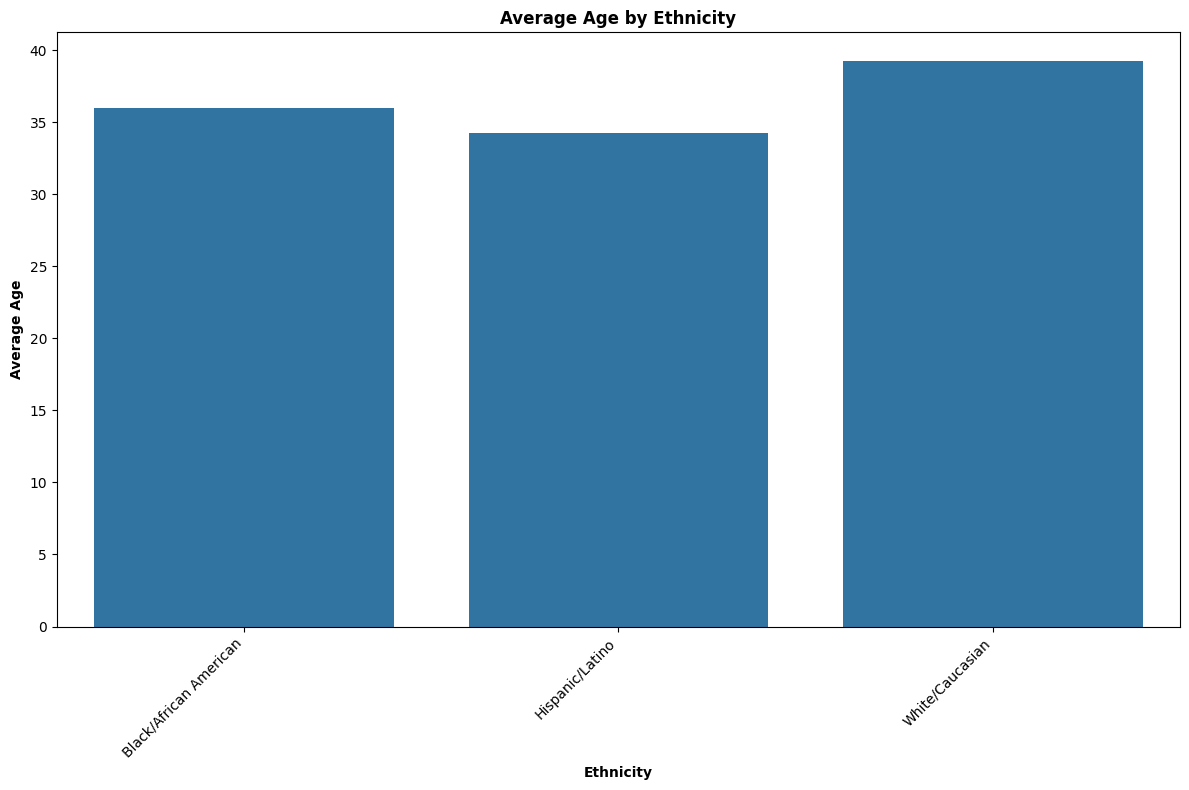

In [ ]:
# calculate average age by ethnicity
average_age_by_ethnicity = modeling_df.groupby('Ethnicity')['Age'].mean()

# create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=average_age_by_ethnicity.index, y=average_age_by_ethnicity.values)
plt.xlabel("Ethnicity", fontweight = 'bold')
plt.ylabel("Average Age", fontweight = 'bold')
plt.title("Average Age by Ethnicity", fontweight = 'bold')
plt.xticks(rotation=45, ha='right')  # rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [ ]:
# display the calculated average age by ethnicity
average_age_by_ethnicity


,Age
Ethnicity,
Black/African American,36.012129
Hispanic/Latino,34.225667
White/Caucasian,39.265206


In [ ]:
clean_df_balanced = modeling_df.copy()

In [ ]:
modeling_df = clean_df_balanced.copy()

In [ ]:
# define crime categories based on keywords
def categorize_charge(description):
    description = str(description).lower().strip()

    if any(word in description for word in ['theft', 'shoplifting', 'robbery', 'burglary', 'larceny', 'stolen', 'pickpocket', 'breaking and entering']):
        return 'Theft & Robbery'
    elif any(word in description for word in ['assault', 'battery','battery on person', 'homicide', 'murder', 'manslaughter', 'domestic violence', 'corporal injury', 'domestic viol', 'domestic relations', 'corpal injury on spouse']):
        return 'Violent Crimes'
    elif any(word in description for word in ['drug', 'narcotic', 'possession', 'paraphernalia', 'trafficking', 'distribution', 'alcohol', 'drinking', 'substance', 'sell controlled', 'purchase controlled', 'marijuana', 'drunk']):
        return 'Drug & Alchol Related'
    elif any(word in description for word in ['fraud', 'forgery', 'embezzlement', 'identity theft', 'bribery', 'money laundering', 'gambling']):
        return 'Fraud & Financial Crimes'
    elif any(word in description for word in ['dui', 'dwi', 'drunk driving', 'reckless driving', 'hit and run', 'vehicular','vehicle', 'drive priv', 'under influence']):
        return 'DUI & Traffic Violations'
    elif any(word in description for word in ['vandalism', 'trespassing', 'arson', 'property damage', 'graffiti', 'railroad', 'leave property', 'property']):
        return 'Property Crimes'
    elif any(word in description for word in ['firearm', 'weapon', 'gun', 'illegal possession', 'unlawful discharge', 'trafficking', 'poss f/', 'carry', 'ADW']):
        return 'Weapons Offenses'
    elif any(word in description for word in ['prostitution', 'solicitation', 'sex', 'indecent exposure', 'sexual assault', 'rape']):
        return 'Sex Crimes'
    elif any(word in description for word in ['warrant', 'failure to appear', 'bench warrant', 'fugitive', 'parole violation', 'violation of parole', 'code']):
        return 'Warrant & Legal Violations'
    elif any(word in description for word in ['public intoxication', 'disorderly conduct', 'disturbing the peace', 'loitering', 'curfew', 'terrorize', 'batt', 'loiter']):
        return 'Public Order Crimes'
    elif any(word in description for word in ['obstruction', 'obstruct', 'resisting arrest', 'perjury', 'contempt', 'harboring fugitive', 'safety']):
        return 'Obstruction of Justice'
    elif any(word in description for word in ['cyber', 'hacking', 'phishing', 'identity fraud', 'online scam']):
        return 'Cyber Crimes'
    else:
        return 'Other Crimes'

# apply the function
modeling_df['Crime Category'] = modeling_df['Charge Description'].apply(categorize_charge)

# check the result
modeling_df[['Charge Description', 'Crime Category']].head()

,Charge Description,Crime Category
0,"ADW, NOT FIREARM, W/GBI",Weapons Offenses
1,SEXUAL BATT-TOUCH INTIMATE PART OF OTHER,Sex Crimes
2,GRAND THEFT MONEY/PROPERTY > $400,Theft & Robbery
3,REFUSE TO LEAVE PROPERTY UPON REQST OWNER,Property Crimes
4,ILLEGAL USE OF TEAR GAS/TEAR GAS WEAPON,Weapons Offenses


In [ ]:
modeling_df['Crime Category'].value_counts()

,count
Crime Category,
Drug & Alchol Related,71895
Violent Crimes,43118
Theft & Robbery,35607
Weapons Offenses,28131
Other Crimes,25513
Property Crimes,21930
DUI & Traffic Violations,19867
Public Order Crimes,18904
Sex Crimes,11216


# **Model Building/ **Balance Ethnicity****

In [ ]:
from sklearn.utils import resample

# create Crime Category BEFORE balancing
clean_df_balanced['Crime Category'] = clean_df_balanced['Charge Description'].apply(categorize_charge)

# drop 'Other/Unknown' & balance AFTER
clean_df_balanced = clean_df_balanced[clean_df_balanced['Ethnicity'] != 'Other/Unknown']

# separate classes
hispanic = clean_df_balanced[clean_df_balanced['Ethnicity'] == 'Hispanic/Latino']
black = clean_df_balanced[clean_df_balanced['Ethnicity'] == 'Black/African American']
white = clean_df_balanced[clean_df_balanced['Ethnicity'] == 'White/Caucasian']

# downsample
hispanic_downsampled = resample(hispanic, replace=False, n_samples=49000, random_state=42)
black_downsampled = resample(black, replace=False, n_samples=49000, random_state=42)
white_downsampled = resample(white, replace=False, n_samples=49000, random_state=42)

# combine
clean_df_balanced = pd.concat([hispanic_downsampled, black_downsampled, white_downsampled])

# shuffle
clean_df_balanced = clean_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

clean_df_balanced.head()



,Report ID,Report Type,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Charge Group Code,Charge Group Description,...,Booking Location,Booking Location Code,Arrest_Day,Arrest_Month,Arrest_Year,Booking_Day,Booking_Month,Booking_Year,Ethnicity,Crime Category
0,6361475,BOOKING,20.0,3,Southwest,362,60,M,4.0,Aggravated Assault,...,77TH ST,4212.0,17,4,2022,17,4,2022,Black/African American,Violent Crimes
1,6638992,BOOKING,1040.0,21,Topanga,2137,25,M,15.0,Against Family/Child,...,VALLEY - JAIL DIV,4279.0,10,7,2023,10,7,2023,White/Caucasian,Violent Crimes
2,6034287,BOOKING,1545.0,12,77th Street,1249,28,F,13.0,Prostitution/Allied,...,77TH ST,4212.0,17,10,2020,17,10,2020,Black/African American,Sex Crimes
3,240407682,RFC,1805.0,4,Hollenbeck,467,46,M,18.0,Drunkeness,...,METRO - JAIL DIVISION,4273.0,18,5,2024,18,5,2024,Hispanic/Latino,Drug & Alchol Related
4,6576190,BOOKING,1845.0,13,Newton,1363,35,M,12.0,Weapon (carry/poss),...,METRO - JAIL DIVISION,4273.0,27,3,2023,27,3,2023,Black/African American,Weapons Offenses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146995,6418465,BOOKING,715.0,10,West Valley,1079,24,M,14.0,Sex (except rape/prst),...,VALLEY - JAIL DIV,4279.0,14,7,2022,14,7,2022,White/Caucasian,Other Crimes
146996,6466052,BOOKING,2230.0,2,Rampart,246,34,M,24.0,Miscellaneous Other Violations,...,METRO - JAIL DIVISION,4273.0,16,9,2022,17,9,2022,White/Caucasian,Warrant & Legal Violations
146997,6797936,BOOKING,1300.0,8,West LA,811,51,M,24.0,Miscellaneous Other Violations,...,VALLEY - JAIL DIV,4279.0,24,4,2024,24,4,2024,White/Caucasian,Property Crimes
146998,6916597,BOOKING,1740.0,17,Devonshire,1795,32,M,15.0,Against Family/Child,...,VALLEY - JAIL DIV,4279.0,11,11,2024,11,11,2024,White/Caucasian,Violent Crimes


In [ ]:
# create a copy for modeling
modeling_df = clean_df_balanced.copy()
# convert categorical features to numerical using LabelEncoder
categorical_columns = ['Area Name', 'Charge Group Description', 'Arrest Type Code',
                       'Charge', 'Crime Category', 'Disposition Description','Report Type', 'Address', 'Location', 'Booking Location', 'Ethnicity', 'Sex Code']

# label encode all columns except Ethnicity first
label_encoders = {}

for col in categorical_columns:
    if col != 'Ethnicity':
        le = LabelEncoder()
        modeling_df[col] = le.fit_transform(modeling_df[col])
        label_encoders[col] = le

# encode Ethnicity separately & safely
ethnicity_encoder = LabelEncoder()
modeling_df['Ethnicity'] = ethnicity_encoder.fit_transform(modeling_df['Ethnicity'])

In [ ]:
modeling_df.head(5)

,Report ID,Report Type,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Charge Group Code,Charge Group Description,...,Booking Location,Booking Location Code,Arrest_Day,Arrest_Month,Arrest_Year,Booking_Day,Booking_Month,Booking_Year,Ethnicity,Crime Category
0,6361475,0,20.0,3,15,362,60,1,4.0,1,...,0,4212.0,17,4,2022,17,4,2022,0,9
1,6638992,0,1040.0,21,16,2137,25,1,15.0,0,...,19,4279.0,10,7,2023,10,7,2023,2,9
2,6034287,0,1545.0,12,0,1249,28,0,13.0,19,...,0,4212.0,17,10,2020,17,10,2020,0,7
3,240407682,1,1805.0,4,5,467,46,1,18.0,6,...,8,4273.0,18,5,2024,18,5,2024,1,1
4,6576190,0,1845.0,13,9,1363,35,1,12.0,25,...,8,4273.0,27,3,2023,27,3,2023,0,11


In [ ]:
num_columns = modeling_df.shape[1]
print(f"Total number of columns: {num_columns}")

Total number of columns: 29


In [ ]:
num_columns = modeling_df.shape[1]
print(f"Total number of columns: {num_columns}")

Total number of columns: 29


In [ ]:
modeling_df.columns

Index(['Report ID', 'Report Type', 'Time', 'Area ID', 'Area Name',
       'Reporting District', 'Age', 'Sex Code', 'Charge Group Code',
       'Charge Group Description', 'Arrest Type Code', 'Charge',
       'Charge Description', 'Disposition Description', 'Address', 'LAT',
       'LON', 'Location', 'Booking Time', 'Booking Location',
       'Booking Location Code', 'Arrest_Day', 'Arrest_Month', 'Arrest_Year',
       'Booking_Day', 'Booking_Month', 'Booking_Year', 'Ethnicity',
       'Crime Category'],
      dtype='object')

In [ ]:
# adding females and males
modeling_df[['Female', 'Male']] = pd.get_dummies(modeling_df['Sex Code'])

In [ ]:
# checking for missing values
missing_values = modeling_df.isnull().sum()
missing_values[missing_values > 0]

,0


In [ ]:
# chekcing which columns are categorical
# None, LETS GO!
categorical_columns = modeling_df.select_dtypes(include='object').columns.tolist()
print(categorical_columns)

['Charge Description']


In [ ]:
modeling_df.columns

Index(['Report ID', 'Report Type', 'Time', 'Area ID', 'Area Name',
       'Reporting District', 'Age', 'Sex Code', 'Charge Group Code',
       'Charge Group Description', 'Arrest Type Code', 'Charge',
       'Charge Description', 'Disposition Description', 'Address', 'LAT',
       'LON', 'Location', 'Booking Time', 'Booking Location',
       'Booking Location Code', 'Arrest_Day', 'Arrest_Month', 'Arrest_Year',
       'Booking_Day', 'Booking_Month', 'Booking_Year', 'Ethnicity',
       'Crime Category', 'Female', 'Male'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split

# define the features to use
features = [
    'Time', 'Area ID', 'Reporting District', 'Age',
    'Charge Group Code', 'Crime Category','Charge Group Description', 'Arrest Type Code',
    'Disposition Description','Arrest_Day', 'Arrest_Month',
       'Arrest_Year', 'Booking_Day', 'Booking_Month', 'Booking_Year', 'Female', 'Male', 'Area Name'
]

X = modeling_df[features]
y = modeling_df['Ethnicity']

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.7, random_state=42)

# confirm dimensions
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((102900, 18), (102900,), (44100, 18), (44100,))

# **Find the Correlation between the columns and Ethnicity**

In [ ]:
modeling_df.columns

Index(['Report ID', 'Report Type', 'Time', 'Area ID', 'Area Name',
       'Reporting District', 'Age', 'Sex Code', 'Charge Group Code',
       'Charge Group Description', 'Arrest Type Code', 'Charge',
       'Charge Description', 'Disposition Description', 'Address', 'LAT',
       'LON', 'Location', 'Booking Time', 'Booking Location',
       'Booking Location Code', 'Arrest_Day', 'Arrest_Month', 'Arrest_Year',
       'Booking_Day', 'Booking_Month', 'Booking_Year', 'Ethnicity',
       'Crime Category', 'Female', 'Male'],
      dtype='object')

In [ ]:
modeling_df.head(5)

,Report ID,Report Type,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Charge Group Code,Charge Group Description,...,Arrest_Day,Arrest_Month,Arrest_Year,Booking_Day,Booking_Month,Booking_Year,Ethnicity,Crime Category,Female,Male
0,6361475,0,20.0,3,15,362,60,1,4.0,1,...,17,4,2022,17,4,2022,0,9,False,True
1,6638992,0,1040.0,21,16,2137,25,1,15.0,0,...,10,7,2023,10,7,2023,2,9,False,True
2,6034287,0,1545.0,12,0,1249,28,0,13.0,19,...,17,10,2020,17,10,2020,0,7,True,False
3,240407682,1,1805.0,4,5,467,46,1,18.0,6,...,18,5,2024,18,5,2024,1,1,False,True
4,6576190,0,1845.0,13,9,1363,35,1,12.0,25,...,27,3,2023,27,3,2023,0,11,False,True


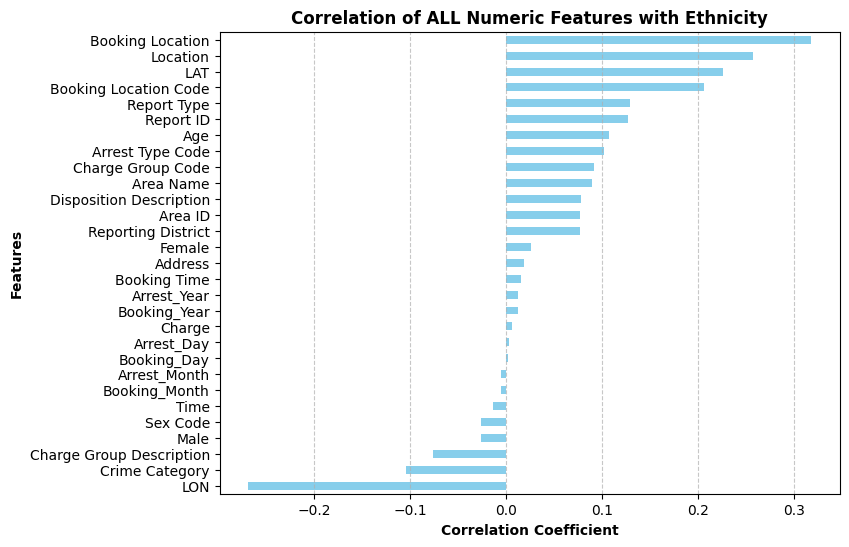

In [ ]:
import matplotlib.pyplot as plt

# compute correlations directly with all columns
correlations = modeling_df.corr(numeric_only=True)["Ethnicity"].sort_values()

# exclude 'Ethnicity' from the plot
correlations = correlations.drop('Ethnicity')

# plot as a bar graph
plt.figure(figsize=(8,6))
correlations.plot(kind='barh', color='skyblue')
plt.title('Correlation of ALL Numeric Features with Ethnicity', fontweight= 'bold')
plt.xlabel('Correlation Coefficient',fontweight= 'bold')
plt.ylabel('Features',fontweight= 'bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


#**Logistic Regression Model**

Accuracy: 0.4247845804988662


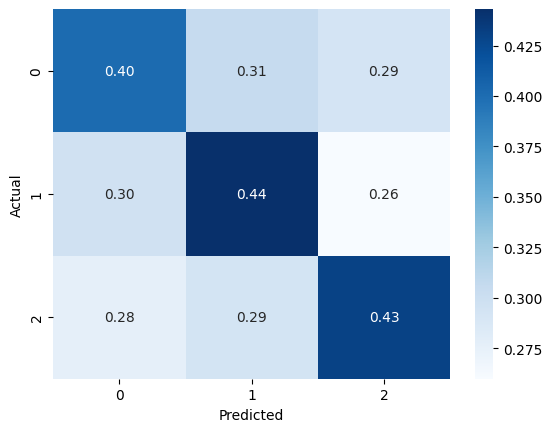

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# define features and target
X = modeling_df[['Time', 'Area ID', 'Reporting District', 'Age', 'Sex Code',
                       'Charge Group Code', 'Arrest Type Code', 'Crime Category',
                       'Arrest_Day', 'Arrest_Month', 'Arrest_Year',
                       'Booking_Day', 'Booking_Month', 'Booking_Year',
                       'Female', 'Male']]

y = modeling_df['Ethnicity']

# encode categorical variables automatically
X = pd.get_dummies(X, drop_first=True)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)

# encode target
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# build the logistic regression model
logr = LogisticRegression(max_iter=1000)

# fit the model
logr.fit(X_train, y_train)

# evaluate
y_pred = logr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# print confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred, normalize="true"), annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# allocate where the string issue is coming from (None anymore)
print(modeling_df.dtypes[modeling_df.dtypes == 'object'])

Charge Description    object
dtype: object


Ran the Logistic Regression with columns I thought were reasonable to have a significant role with ethnicity, but the accuracy score I got was a 42%, so need to drop the columns that don't play a role at all such as:


I am also double-checking to see if its safe to drop the columns I want to with a Random Forest feature importance.

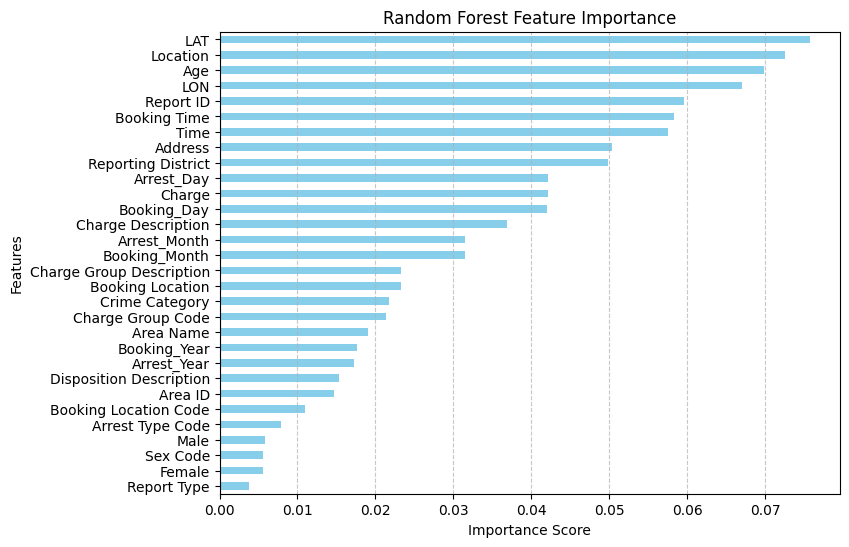

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# features and Target
X = modeling_df.drop(columns=['Ethnicity'])
y = modeling_df['Ethnicity']

# ----> Create a LabelEncoder object
le = LabelEncoder()

# ----> Iterate through columns and encode if they are of type 'object'
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = le.fit_transform(X[col])

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)

# random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# get feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values()

# plot feature importances
plt.figure(figsize=(8,6))
importances.plot(kind='barh', color='skyblue')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

From these results what I can read is that, the model is mostly relying on geographical, temporal, and age related features to predict ethnicity.
Surprisingly Geneder isn't a good predictor for ethnicity.


Random Forrest Most important features

In [ ]:
# Checking to see how LAT, LON, and Location all are similar.
location_data = modeling_df[['LAT', 'LON', 'Location']]
location_data

,LAT,LON,Location
0,34.0141,-118.3501,16781
1,34.2065,-118.5906,30095
2,33.9761,-118.2827,8867
3,34.0426,-118.2073,1102
4,33.9997,-118.2630,5486
...,...,...,...
146995,34.1621,-118.4721,26461
146996,34.0591,-118.2739,7246
146997,34.0385,-118.5556,29136
146998,34.2211,-118.5230,28088


Accuracy: 0.41714285714285715


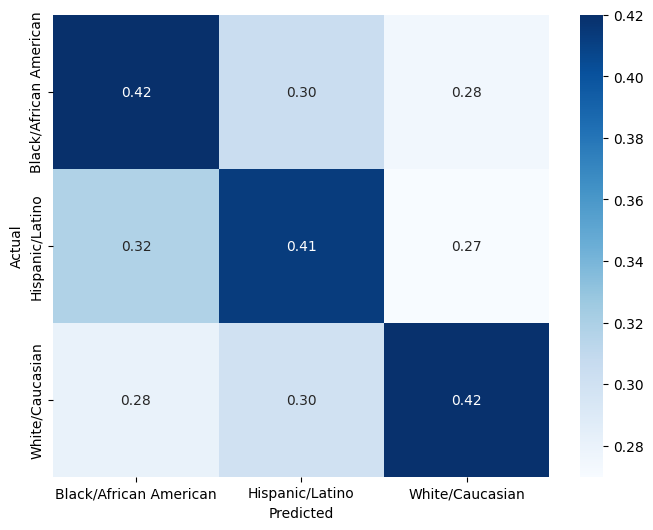

In [ ]:
from sklearn.metrics import confusion_matrix

# define features and target
X = modeling_df[['Time', 'Area ID', 'Reporting District', 'Age',
    'Charge Group Code', 'Arrest Type Code', 'Arrest_Day',
    'Arrest_Month', 'Arrest_Year', 'Booking_Day',
    'Booking_Month', 'Booking_Year', 'Crime Category',
    'LAT', 'LON']]

y = modeling_df['Ethnicity']

# encode categorical variables automatically
X = pd.get_dummies(X, drop_first=True)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)

# encode target
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# build the logistic regression model
logr = LogisticRegression(max_iter=1000)

# fit the model
logr.fit(X_train, y_train)

# evaluate
y_pred = logr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Calculate the confusion matrix here
conf_matrix = confusion_matrix(y_test, y_pred, normalize="true")

# print confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt=".2f", xticklabels=["Black/African American", "Hispanic/Latino", "White/Caucasian"], yticklabels=["Black/African American", "Hispanic/Latino", "White/Caucasian"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The Logistic Regression is bad because the data is filled with non-linear patterns which is complex for logistics models to run.

# **Trying an XGboost to see how we can differentiate**

XGBoost Accuracy: 0.5933560090702947


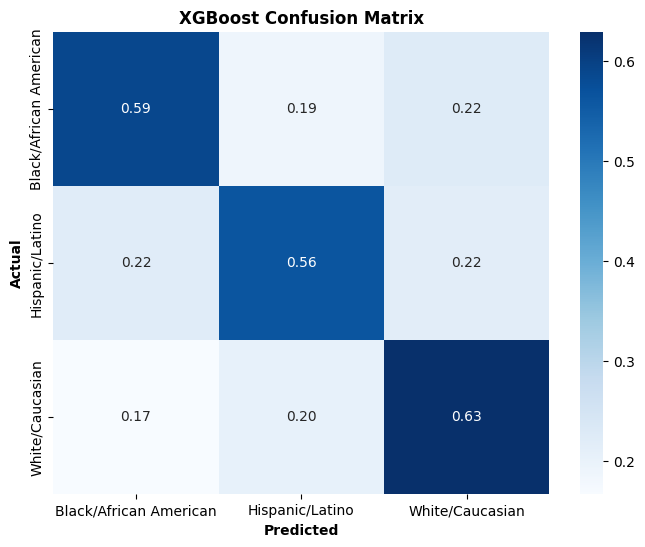

In [ ]:
from xgboost import XGBClassifier

# features and target
X = modeling_df[[
    'Time', 'Area ID', 'Reporting District', 'Age',
    'Charge Group Code', 'Arrest Type Code', 'Arrest_Day',
    'Arrest_Month', 'Arrest_Year', 'Booking_Day',
    'Booking_Month', 'Booking_Year', 'Crime Category',
    'LAT', 'LON', 'Area Name'
]]

y = modeling_df['Ethnicity']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)

# encode target
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# train XGBoost Model
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# evaluate
y_pred = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))

# confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred, normalize="true")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt=".2f", xticklabels=["Black/African American", "Hispanic/Latino", "White/Caucasian"], yticklabels=["Black/African American", "Hispanic/Latino", "White/Caucasian"])
plt.xlabel("Predicted", fontweight = 'bold')
plt.ylabel("Actual", fontweight = 'bold')
plt.title("XGBoost Confusion Matrix", fontweight = 'bold')
plt.show()

**Randomized Search for best parameters!**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb_random = XGBClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_random,
    param_distributions=param_dist,
    n_iter=20,   # limits the number of trials so it doesn't run forever
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters (RandomizedSearch):", random_search.best_params_)
print("Best Accuracy (RandomizedSearch):", random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters (RandomizedSearch): {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Best Accuracy (RandomizedSearch): 0.5926239067055393


**GridSearch for Best Parameters**

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

xgb_grid = XGBClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_grid,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters (GridSearch):", grid_search.best_params_)
print("Best Accuracy (GridSearch):", grid_search.best_score_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters (GridSearch): {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Best Accuracy (GridSearch): 0.592536443148688


# **Final Tune (Updated XGboost)**

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Fine-Tuned Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.08, 'max_depth': 6, 'n_estimators': 250, 'subsample': 0.9}
Best Fine-Tuned Accuracy: 0.5930126336248785
Fine-Tuned Final Test Accuracy: 0.5932426303854875


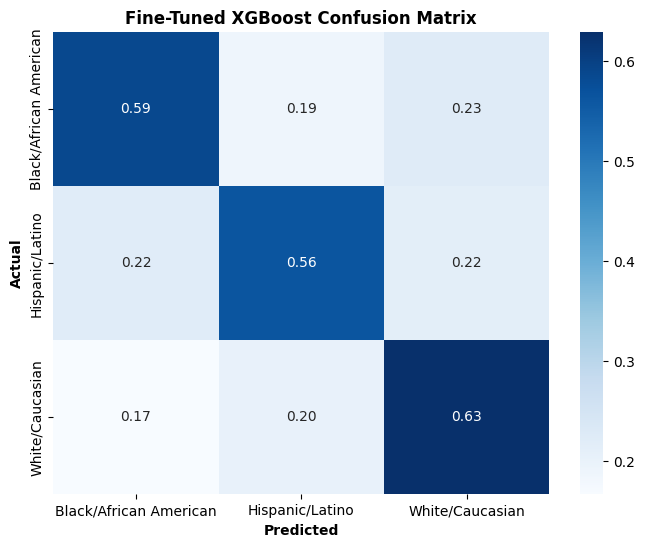

In [ ]:
from sklearn.model_selection import GridSearchCV

fine_tune_params = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.08, 0.1, 0.12],
    'n_estimators': [150, 200, 250],
    'subsample': [0.9],  # fixed
    'colsample_bytree': [0.9]  # fixed
}

xgb_finetune = XGBClassifier(random_state=42)

fine_tune_search = GridSearchCV(
    estimator=xgb_finetune,
    param_grid=fine_tune_params,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

fine_tune_search.fit(X_train, y_train)

print("Best Fine-Tuned Parameters:", fine_tune_search.best_params_)
print("Best Fine-Tuned Accuracy:", fine_tune_search.best_score_)

# Final evaluation
best_xgb_finetuned = fine_tune_search.best_estimator_
y_pred_fine = best_xgb_finetuned.predict(X_test)

print("Fine-Tuned Final Test Accuracy:", accuracy_score(y_test, y_pred_fine))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_fine, normalize="true")
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt=".2f", xticklabels=["Black/African American", "Hispanic/Latino", "White/Caucasian"], yticklabels=["Black/African American", "Hispanic/Latino", "White/Caucasian"])
plt.title("Fine-Tuned XGBoost Confusion Matrix", fontweight = 'bold')
plt.xlabel("Predicted", fontweight = 'bold')
plt.ylabel("Actual", fontweight = 'bold')
plt.show()


# **Location Analysis: Why the features lean more towards the Locational Features**

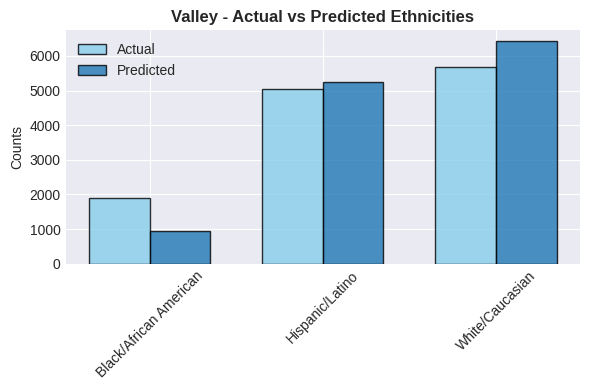

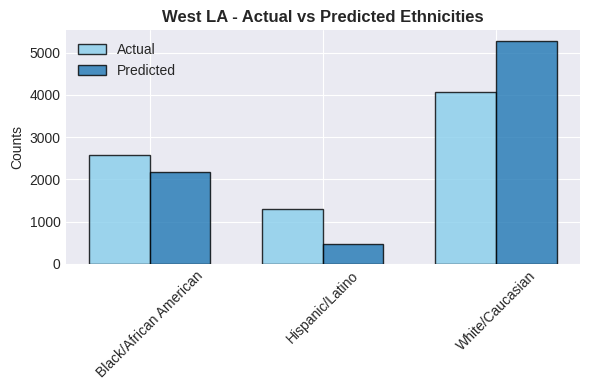

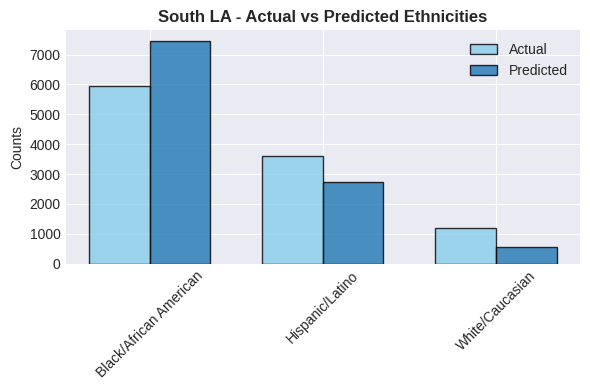

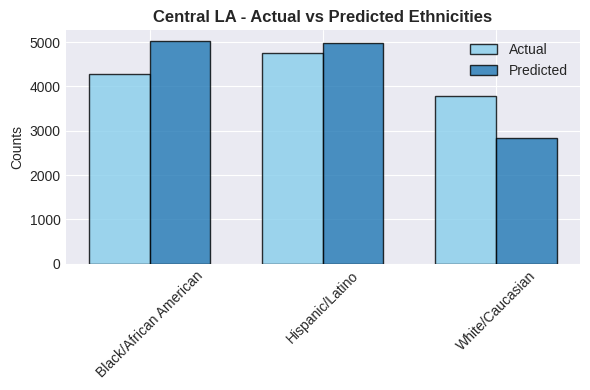

In [ ]:
# create a copy for modeling
modeling_df = clean_df_balanced.copy()


modeling_df[['Female', 'Male']] = pd.get_dummies(modeling_df['Sex Code'])

# convert categorical features to numerical using LabelEncoder
categorical_columns = ['Area Name', 'Charge Group Description', 'Arrest Type Code',
                       'Charge', 'Crime Category', 'Disposition Description','Report Type', 'Address', 'Location', 'Booking Location', 'Ethnicity', 'Sex Code']

# Label encode all columns except Ethnicity first
label_encoders = {}

for col in categorical_columns:
    if col != 'Ethnicity':
        le = LabelEncoder()
        modeling_df[col] = le.fit_transform(modeling_df[col])
        label_encoders[col] = le

# Encode Ethnicity separately & safely
ethnicity_encoder = LabelEncoder()
modeling_df['Ethnicity'] = ethnicity_encoder.fit_transform(modeling_df['Ethnicity'])

X = modeling_df[features]
y = modeling_df['Ethnicity']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.7, random_state=42)

ethinicity_analysis_df = X_test.copy().reset_index(drop=True)

for col in categorical_columns:
    if col != 'Ethnicity' and col in ethinicity_analysis_df.columns:
        le = label_encoders.get(col)
        if le:
            ethinicity_analysis_df[col] = le.inverse_transform(ethinicity_analysis_df[col])

# Correct decoding
ethinicity_analysis_df['Ethnicity'] = ethnicity_encoder.inverse_transform(y_test)
ethinicity_analysis_df['preds'] = ethnicity_encoder.inverse_transform(y_pred)
ethinicity_analysis_df[['Ethnicity', 'preds']]


# Creating a mapping dictionary for the regions
area_mapping = {
    # Downtown/Central LA
    'Central': 'Central LA',
    'Rampart': 'Central LA',
    'Wilshire': 'Central LA',
    'Olympic': 'Central LA',
    'Northeast': 'Central LA',
    'Hollenbeck': 'Central LA',
    # South LA
    '77th Street': 'South LA',
    'Southwest': 'South LA',
    'Southeast': 'South LA',
    'Newton': 'South LA',
    'Harbor': 'South LA',
    # West LA
    'Hollywood': 'West LA',
    'Pacific': 'West LA',
    'West LA': 'West LA',
    # Valley
    'Van Nuys': 'Valley',
    'N Hollywood': 'Valley',
    'Mission': 'Valley',
    'Topanga': 'Valley',
    'Devonshire': 'Valley',
    'Foothill': 'Valley',
    'West Valley': 'Valley'
}
# Adding the new column with the region mapping
ethinicity_analysis_df['Region'] = ethinicity_analysis_df['Area Name'].map(area_mapping)

# Make sure only valid ethnicities are considered
valid_ethnicities = ['Black/African American', 'Hispanic/Latino', 'White/Caucasian']
ethinicity_analysis_df = ethinicity_analysis_df[ethinicity_analysis_df['Ethnicity'].isin(valid_ethnicities)]

regions = ['Valley', 'West LA', 'South LA', 'Central LA']

for region in regions:
    region_df = ethinicity_analysis_df[ethinicity_analysis_df['Region'] == region]

    # Prepare counts
    actual_counts = region_df['Ethnicity'].value_counts().reindex(valid_ethnicities, fill_value=0)
    pred_counts = region_df['preds'].value_counts().reindex(valid_ethnicities, fill_value=0)

    # Plot
    plt.figure(figsize=(6,4))
    plt.style.use('seaborn-v0_8-darkgrid')
    bar_width = 0.35
    index = np.arange(len(valid_ethnicities))

    plt.bar(index, actual_counts, bar_width, label='Actual', alpha=0.8, color='skyblue', edgecolor='black')
    plt.bar(index + bar_width, pred_counts, bar_width, label='Predicted', alpha=0.8, edgecolor='black')

    plt.xticks(index + bar_width / 2, valid_ethnicities, rotation=45)
    plt.title(f"{region} - Actual vs Predicted Ethnicities", fontweight='bold')
    plt.ylabel("Counts")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Finding the Optimal "k" for nearest neighbors. Using the Elbow Method.

In [ ]:
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.metrics import accuracy_score

#k_range = range(1, 51)  # Try k=1 to k=50
#accuracies = []

#for k in k_range:
   # knn = KNeighborsClassifier(n_neighbors=k)
    # knn.fit(X_train, y_train)
    # y_pred = knn.predict(X_test)
    # acc = accuracy_score(y_test, y_pred)
    # accuracies.append(acc)

# Plot the elbow curve
# plt.figure(figsize=(8,5))
# plt.plot(k_range, accuracies, marker='o')
# plt.title("KNN Accuracy vs. k (Elbow Curve)")
# plt.xlabel("Number of Neighbors (k)")
# plt.ylabel("Accuracy")
# plt.grid(True)
# plt.show()

This took 47 minutes to run # **Do not run again!**

However, the optimal K is = (35)

# **Nearest Neighbors**

KNN Accuracy: 0.4879818594104308

Classification Report:

                        precision    recall  f1-score   support

Black/African American       0.49      0.51      0.50     14700
       Hispanic/Latino       0.48      0.45      0.46     14700
       White/Caucasian       0.49      0.50      0.50     14700

              accuracy                           0.49     44100
             macro avg       0.49      0.49      0.49     44100
          weighted avg       0.49      0.49      0.49     44100



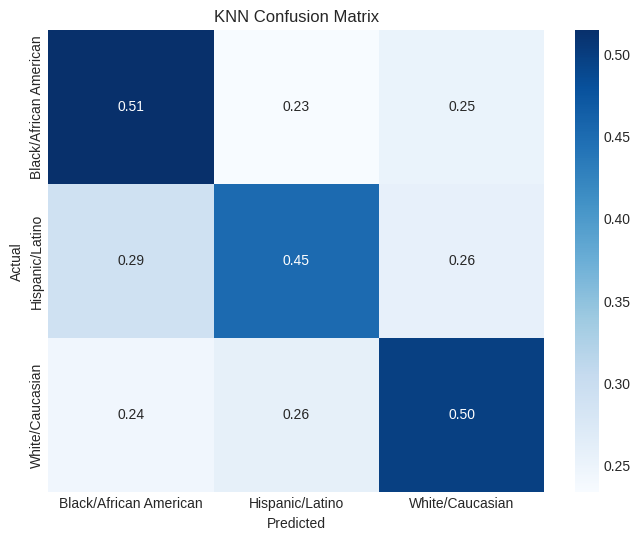

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.7, stratify=y, random_state=42)

# KNN Model (start with k=5)
knn_model = KNeighborsClassifier(n_neighbors=35)
knn_model.fit(X_train, y_train)

# Predictions
y_pred_knn = knn_model.predict(X_test)

# Accuracy
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))

# F1, Precision, Recall Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_knn, target_names=["Black/African American", "Hispanic/Latino", "White/Caucasian"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_knn, normalize="true")
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt=".2f", xticklabels=["Black/African American", "Hispanic/Latino", "White/Caucasian"], yticklabels=["Black/African American", "Hispanic/Latino", "White/Caucasian"])
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# **Soft Voting Ensemble**

Ensemble Accuracy: 0.5885034013605442
              precision    recall  f1-score   support

           0       0.60      0.59      0.60     14700
           1       0.58      0.56      0.57     14700
           2       0.58      0.62      0.60     14700

    accuracy                           0.59     44100
   macro avg       0.59      0.59      0.59     44100
weighted avg       0.59      0.59      0.59     44100



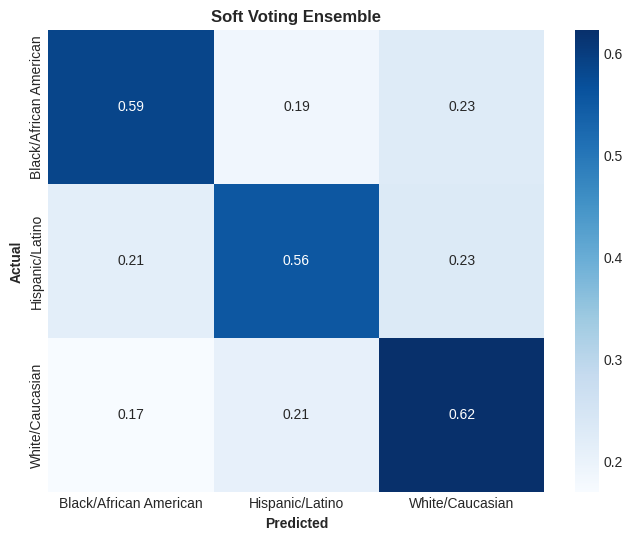

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# define the individual models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=250, subsample=0.9, colsample_bytree=0.9, random_state=42)
knn = KNeighborsClassifier(n_neighbors=35)

# create the voting ensemble (soft voting)
ensemble = VotingClassifier(estimators=[
    ('rf', rf),
    ('xgb', xgb),
    ('knn', knn)
], voting='soft', n_jobs=-1)

# fit the model
ensemble.fit(X_train, y_train)

# predictions
y_pred = ensemble.predict(X_test)

# evaluate
print("Ensemble Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred, normalize="true")
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt=".2f", xticklabels=["Black/African American", "Hispanic/Latino", "White/Caucasian"], yticklabels=["Black/African American", "Hispanic/Latino", "White/Caucasian"])
plt.title("Soft Voting Ensemble", fontweight = "bold")
plt.xlabel("Predicted", fontweight = "bold")
plt.ylabel("Actual", fontweight = "bold")
plt.show()

# **Hard Voting Ensemble**

Ensemble Accuracy: 0.5882086167800453
              precision    recall  f1-score   support

           0       0.59      0.61      0.60     14700
           1       0.59      0.54      0.57     14700
           2       0.59      0.61      0.60     14700

    accuracy                           0.59     44100
   macro avg       0.59      0.59      0.59     44100
weighted avg       0.59      0.59      0.59     44100



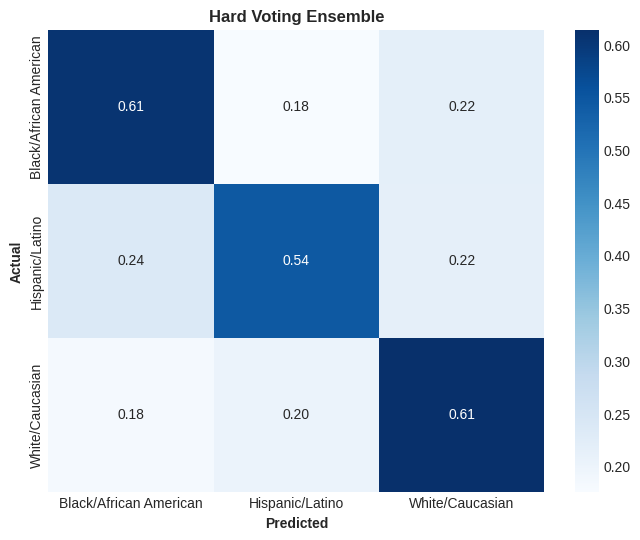

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# define the individual models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=250, subsample=0.9, colsample_bytree=0.9, random_state=42)
knn = KNeighborsClassifier(n_neighbors=35)

# create the voting ensemble (hard voting)
ensemble = VotingClassifier(estimators=[
    ('rf', rf),
    ('xgb', xgb),
    ('knn', knn)
], voting='hard', n_jobs=-1)

# fit the model
ensemble.fit(X_train, y_train)

# predictions
y_pred = ensemble.predict(X_test)

# evaluate
print("Ensemble Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred, normalize="true")
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt=".2f",
            xticklabels=["Black/African American", "Hispanic/Latino", "White/Caucasian"],
            yticklabels=["Black/African American", "Hispanic/Latino", "White/Caucasian"])
plt.title("Hard Voting Ensemble", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("Actual", fontweight="bold")
plt.show()

# **Important Features for KNN and XGB**

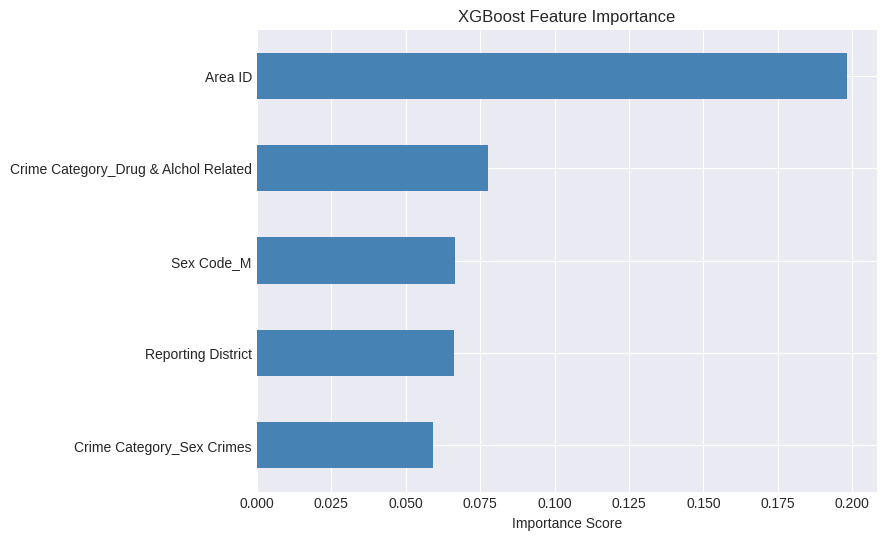

In [ ]:
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

# === XGBoost Feature Importance (Top 5) ===
xgb_model = XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=250,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)
xgb_model.fit(X_train, y_train)

xgb_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
xgb_importances = xgb_importances.sort_values(ascending=False).head(5)

plt.figure(figsize=(8, 6))
xgb_importances.plot(kind='barh', color='steelblue')
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()

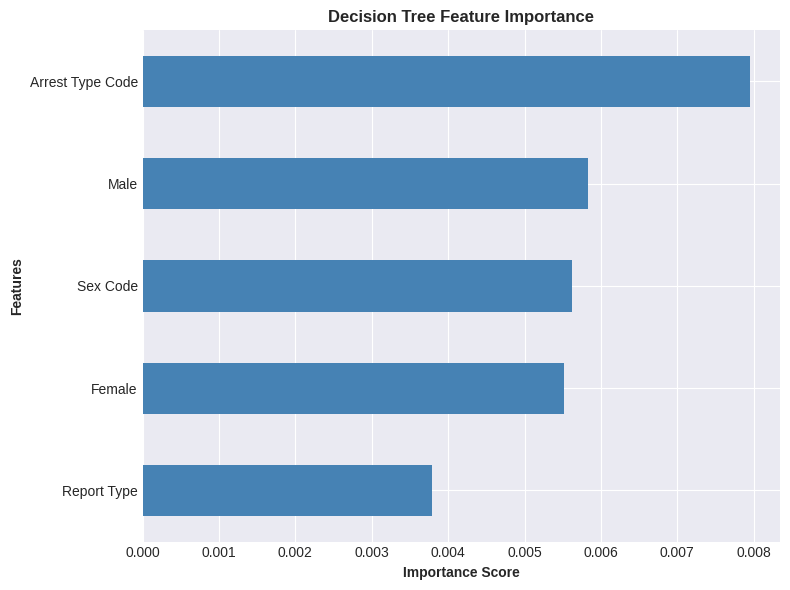

In [ ]:
# Random Forest Feature Importance (Top 5) without grid lines
plt.figure(figsize=(8, 6))

# Get the top 5 importances and sort them
top_5_importances = importances.head(5).sort_values()

top_5_importances.plot(kind='barh', color='steelblue')

plt.title("Decision Tree Feature Importance", fontweight = 'bold')
plt.xlabel("Importance Score", fontweight = 'bold')
plt.ylabel("Features", fontweight = 'bold')
plt.tight_layout()
plt.show()